# Doublets 😎🦒

In [6]:
from IPython import get_ipython

if get_ipython():
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")

import numpy as np
import pandas as pd
import torch

import xarray as x

import matplotlib.pyplot as plt
import seaborn as sns

import collections

import latenta as la

la.logger.setLevel("INFO")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 0. Simulate data of the two cell types
Data containing only cells 100% of a cell type

In [7]:
n_sgl_cells = 1000
sgl_cell_ids = [str(i) for i in range(n_sgl_cells)]
sgl_cells = la.Dim("C" + pd.Series(sgl_cell_ids, name="cell"))

n_genes = 100
genes = la.Dim("G" + pd.Series([str(i) for i in range(n_genes)]), name="gene")

celltype_ids = "Ct" + pd.Series(["a", "b"])
celltypes = la.Dim(celltype_ids, name = "celltype")

In [8]:
#Baseline expression, same as before
real_baseline_expression_value = pd.DataFrame(np.random.normal(scale = 3, size = (celltypes.size, genes.size)), index = celltypes.index, columns = genes.index)
real_baseline_expression = la.Fixed(real_baseline_expression_value, label = "baseline_real")

In [9]:
#Real proportions are not exactly 100% of one cell type as we might expect some ambient mRNA
real_sgl_proportions_value = pd.DataFrame(np.random.dirichlet((0.09,0.09), size = n_sgl_cells), index = sgl_cells.index,
                                 columns = celltypes.index)
real_sgl_proportions = la.Fixed(real_sgl_proportions_value, label = "proportion_sgl_real")

In [10]:
real_sgl_proportions

proportion_sgl_real:  ↦ Fixed [cell (1000), celltype (2)]

In [11]:
# Expression prop * baseline expression
expression_sgl_sim = la.links.vector.Matmul(real_sgl_proportions, real_baseline_expression, label = "expression_sgl_sim")
expression_sgl_sim.plot()

In [12]:
# Introduce noise, as a normal distribution
sim_sgl_dist = la.distributions.Normal(expression_sgl_sim, la.Fixed(0.001), label = "dist")
sim_sgl_dist.plot()

In [13]:
# Sample from posterior
posterior_sgl_sim = la.posterior.Posterior(sim_sgl_dist)
posterior_sgl_sim.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

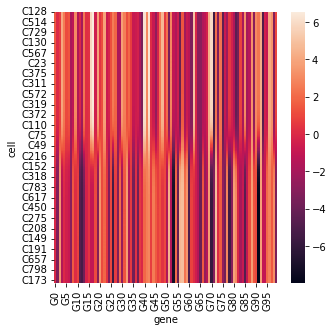

In [14]:
observation_value_slg_sim = posterior_sgl_sim.samples[sim_sgl_dist].sel(sample=0).to_pandas()
fig, (ax0) = plt.subplots(1, 1, figsize=(5, 5))
cell_order = real_sgl_proportions_value[celltype_ids[0]].sort_values().index
sns.heatmap(observation_value_slg_sim.loc[cell_order], ax=ax0)

# 1. Infer baseline
Using the simulated 100% cell type data, infer the baseline gene expression per cell types

In [15]:
# Baseline is the variable of interest, modeled as latent
baseline_p = la.distributions.Normal(
    loc=la.Parameter(0.0), scale=la.Parameter(1.0, transforms=[la.transforms.Exp()])
)
latent_baseline = la.Latent(
    p=baseline_p, definition=la.Definition([genes, celltypes]), label="baseline"
)
latent_baseline.plot()

In [16]:
# We simulated the data with the "real" proportions being not exactly a 100% however we would not be able to know the real prop
# therefore we now need to use the "observed proportion", being set to 1 for the highest prop cell type
observed_proportion_value = (real_sgl_proportions_value.T == real_sgl_proportions_value.max(axis=1)).T.astype(int).astype(float) #Create a boolean matrix T for the value == to max by row and convert it to int
#sns.scatterplot(
#        x = real_proportions_value[celltype_ids[0]], 
#        y = observed_proportion_value[celltype_ids[0]]
#    )

In [17]:
# proportion is fixed
observed_proportions = la.Fixed(observed_proportion_value, label = "proportion_observed")

In [18]:
expression_forBaseline = la.links.vector.Matmul(latent_baseline, observed_proportions, label = "expression_forBaseline")
expression_forBaseline.plot()

In [19]:
expression_p = la.distributions.Normal(loc = expression_forBaseline)
transcriptome_forBaseline = la.Observation(
    value=observation_value_slg_sim, p=expression_p, 
    definition=la.Definition.from_xr(observation_value_slg_sim), label = "transcriptome_forBaseline"
)

transcriptome_forBaseline.plot()

In [20]:
inference = la.infer.svi.SVI(
    transcriptome_forBaseline, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.05)
)
trainer = la.infer.trainer.Trainer(inference)

  0%|                                                                                                         …

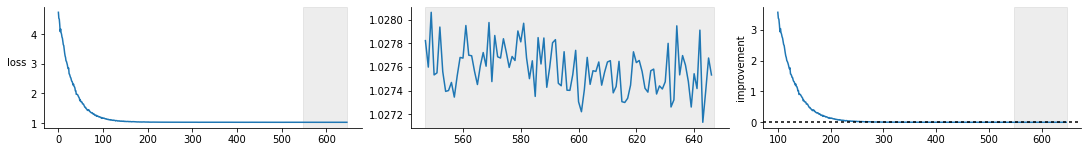

In [21]:
trace = trainer.train(10000)
trace.plot()

In [22]:
transcriptome_forBaseline_posterior = la.posterior.Observed(
    transcriptome_forBaseline, retain_samples={expression_forBaseline.x}
)
transcriptome_forBaseline_posterior.sample(100)

  0%|          | 0/100 [00:00<?, ?it/s]

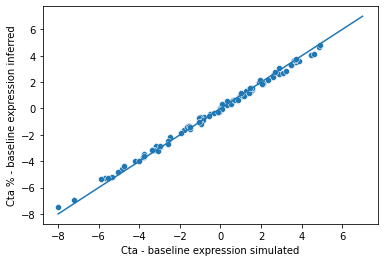

In [23]:
x = np.linspace(-8, 7, 10)
sns.scatterplot(
        x = real_baseline_expression_value.loc[celltype_ids[0],:], 
        y = transcriptome_forBaseline_posterior.samples[expression_forBaseline.x].mean("sample").to_pandas()[celltype_ids[0]]
    )
plt.xlabel('Cta - baseline expression simulated')
plt.ylabel('Cta % - baseline expression inferred')
plt.plot(x, x + 0, linestyle='solid')

# 2. Simulate data with doublets
Add cells ~50/50% of the two cell types in which we will also modify the gene expression due to the interaction between the two cell types

In [54]:
# Create 50 doublet cells
#proportions_value = pd.DataFrame(np.concatenate((np.random.dirichlet((0.3,0.3), size = 50), np.random.dirichlet((50,50), size = 50))), 
#                                 index = cells.index, columns = celltypes.index)
n_dbl_cells = 1000
dbl_cell_ids = [str(i) for i in range(n_sgl_cells, (n_dbl_cells+n_sgl_cells))]
dbl_cell_ids = "C" + pd.Series(dbl_cell_ids, name = "cell")
dbl_cell = la.Dim(dbl_cell_ids)

In [55]:
real_dbl_proportions_value = pd.DataFrame(np.random.dirichlet((50,50), size = n_dbl_cells), index = dbl_cell_ids, columns= celltypes.index)

In [56]:
real_dbl_proportions_value.index.name

'cell'

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  2.,
         1.,  2.,  3.,  6.,  4.,  8.,  9., 11.,  8.,  6.,  9., 14., 12.,
        17., 16., 19., 19., 28., 30., 27., 29., 34., 36., 35., 29., 33.,
        35., 46., 30., 34., 23., 40., 40., 17., 23., 27., 31., 17., 20.,
        19., 25., 11., 12., 15., 13., 13., 10.,  6., 11.,  5.,  3.,  8.,
         3.,  1.,  1.,  1.,  3.,  1.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.]),
 array([0.32736523, 0.33162502, 0.3358848 , 0.34014459, 0.34440437,
        0.34866415, 0.35292394, 0.35718372, 0.36144351, 0.36570329,
        0.36996308, 0.37422286, 0.37848265, 0.38274243, 0.38700221,
        0.391262  , 0.39552178, 0.39978157, 0.40404135, 0.40830114,
        0.41256092, 0.41682071, 0.42108049, 0.42534027, 0.42960006,
        0.43385984, 0.43811963, 0.44237941, 0.4466392 , 0.45089898,
        0.45515877, 0.45941855, 0.46367833, 0.46793812, 0.4721979 ,
        0.47645769, 0.48071747, 0.48497726, 0.48923704, 0.49349683

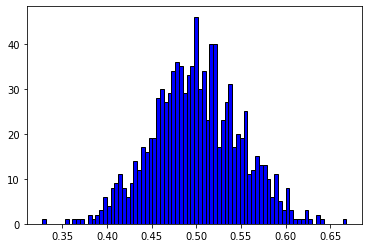

In [57]:
plt.hist(real_dbl_proportions_value.Cta, color = 'blue', edgecolor = 'black',
         bins = 80)

In [58]:
real_dbl_proportions = la.Fixed(real_dbl_proportions_value, label = "proportion_dbl_real")
real_dbl_proportions

proportion_dbl_real:  ↦ Fixed [cell (1000), celltype (2)]

In [59]:
#Add the effect of cell interaction
#For 50% of the genesthere will be a modifier value, which is randomly positive or negative, from a normal distribution of mean 1, sd 3
#There is a specific value for each cell type
baseline_modifier_value = (np.random.random(real_baseline_expression.shape) > 0.7)*(np.random.choice([-1, 1], real_baseline_expression.shape))*(np.random.normal(1.0, 1.0, real_baseline_expression.shape))
baseline_modifier = la.Fixed(baseline_modifier_value, definition = real_baseline_expression, label = "modifier")
baseline_modifier_value = baseline_modifier.prior_pd()
baseline_modifier_value

gene,G0,G1,G2,G3,G4,G5,G6,G7,G8,G9,...,G90,G91,G92,G93,G94,G95,G96,G97,G98,G99
celltype,,,,,,,,,,,,,,,,,,,,,
Cta,0.0,0.152199,-0.0,0.229409,-0.0,-0.0,-0.000000,0.0,0.0,0.0,...,-0.0,-0.741674,0.0,0.0,-0.84459,0.0,-0.665979,0.800564,2.530205,0.000000
Ctb,-0.0,0.982233,0.0,1.409285,0.0,0.0,-1.043105,0.0,-0.0,0.0,...,0.0,1.076850,0.0,0.0,0.00000,0.0,-0.088489,0.000000,0.000000,1.260614


In [60]:
responded_baseline_expression = la.links.scalar.Linear(real_baseline_expression, b = baseline_modifier, label = "baseline_responded")

In [61]:
# expression = la.links.vector.Matmul(proportions, baseline_expression, output = la.Definition([cells, genes]), label = "expression")
expression_dbl_sim = la.links.vector.Matmul(real_dbl_proportions, responded_baseline_expression, definition = la.Definition([dbl_cell, genes]), label = "expression_dbl_sim")

In [62]:
expression_dbl_sim.plot()

In [63]:
noise = la.Fixed(0.001)

In [64]:
dist_dbl = la.distributions.Normal(expression_dbl_sim, noise, label = "dist_dbl_sim")

In [65]:
dist_dbl.plot()

In [66]:
posterior_dbl_sim = la.posterior.Posterior(dist_dbl)
posterior_dbl_sim.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

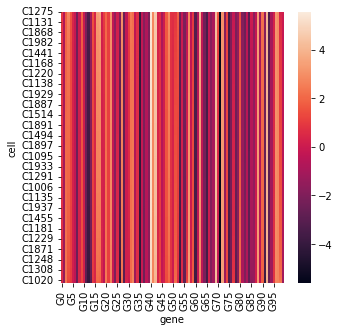

In [67]:
observation_value_dbl_sim = posterior_dbl_sim.samples[dist_dbl].sel(sample=0).to_pandas()
fig, (ax0) = plt.subplots(1, 1, figsize=(5, 5))
cell_order = real_dbl_proportions_value[celltype_ids[0]].sort_values().index
sns.heatmap(observation_value_dbl_sim.loc[cell_order], ax=ax0)

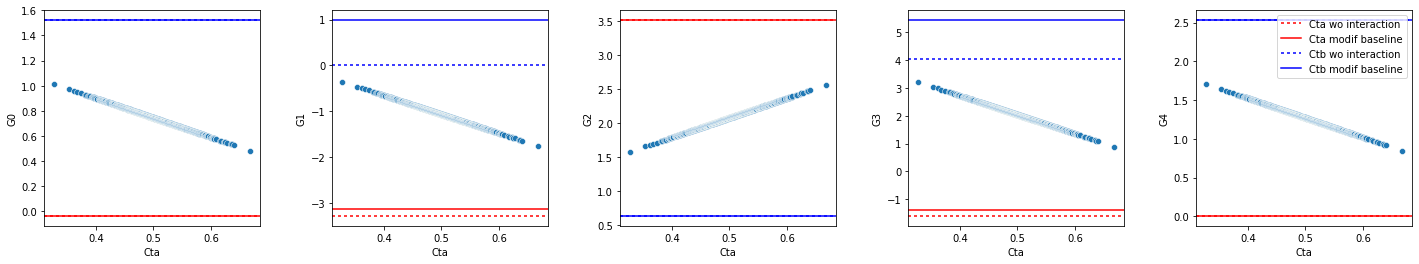

In [68]:
gene_ids_oi = genes.coords[:5]

fig, axes = la.plotting.axes_wrap(len(gene_ids_oi))

for gene_id, ax in zip(gene_ids_oi, axes):
    # print(gene_id, )
    # print(baseline_modifier.prior_pd()[gene_id])
    sns.scatterplot(
        x = real_dbl_proportions_value.loc[cell_order, celltype_ids[0]],
        y = observation_value_dbl_sim.loc[cell_order][gene_id],
        ax = ax
    )
    for color, celltype in zip(["red", "blue"], celltype_ids):
        ax.axhline(real_baseline_expression_value.loc[celltype, gene_id], label = celltype + " wo interaction", color = color, dashes = (2, 2))
        ax.axhline(real_baseline_expression_value.loc[celltype, gene_id] + baseline_modifier_value.loc[celltype, gene_id], label = celltype + " modif baseline", color = color)
plt.legend()

Combine expression of singlets and doublets

# 3. Infer proportions
We have the baseline (per gene) per cell type in 100% cells
        transcriptome data containing doublets
We want to try to infer the proportions of each cell types in these cells

In [70]:
#Let's first try only on the doublets 
latent_proportion = la.Latent(
    p=la.distributions.Dirichlet(la.Fixed(np.array([1.,1.]), definition = [celltypes])), 
    definition=la.Definition([dbl_cell, celltypes]), label="proportion"
)
latent_proportion.plot()

In [73]:
baseline_expression_clone = latent_baseline.q.clone()
baseline_expression_clone.plot()

In [74]:
baseline_expression_clone.replace(la.variables.find_replace.find_optimizable, la.variables.find_replace.replace_optimizable_fixed) 
# replace(what we find is true, by that) 
# Here we replace all the optimizable, so free parameters, by fixed values

q: scale, loc ↦ Normal [gene (•), celltype (•)]

In [75]:
modifier_p = la.distributions.Normal(
    loc=la.Parameter(0.0), scale=la.Parameter(1, transforms=[la.transforms.Exp()])
)
latent_modifier = la.Latent(
    p=modifier_p, definition=la.Definition([genes, celltypes]), label="modifier"
)
latent_modifier.plot() 

In [76]:
baseline_interaction = la.links.scalar.Linear(latent_modifier, b = baseline_expression_clone, label = "baseline")
baseline_interaction.plot()

In [77]:
expression = la.links.vector.Matmul(baseline_interaction, latent_proportion, label="expression")
expression.plot()

In [78]:
expression_p = la.distributions.Normal(loc = expression)
transcriptome = la.Observation(
    value=observation_value_dbl_sim, p=expression_p, definition=la.Definition.from_xr(observation_value_dbl_sim), label = "transcriptome"
)

transcriptome.plot()

In [79]:
inference = la.infer.svi.SVI(
    transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.05)
)
trainer = la.infer.trainer.Trainer(inference)

In [80]:
trace = trainer.train(10000)
trace.plot()

  0%|                                                                                                         …

InferenceError: During run at transcriptome.p.loc.a

In [ ]:
transcriptome_observed = la.posterior.Observed(
    transcriptome, retain_samples={expression.a, expression.x.x}
)
transcriptome_observed.sample(100)

In [ ]:
x = np.linspace(0, 1, 10)
sns.scatterplot(
        x = real_dbl_proportions_value[celltype_ids[0]], #proportion cell type a 
        y = transcriptome_observed.samples[expression.a].mean("sample").to_pandas()[celltype_ids[0]]
    )
plt.xlabel('Cta % - simulated')
plt.ylabel('Cta % - inferred')
plt.plot(x, x + 0, linestyle='solid')

In [ ]:
transcriptome_observed.samples[expression.x.x].mean("sample").to_pandas()

In [ ]:
x = np.linspace(-5, 5, 10)
sns.scatterplot(
        x = baseline_modifier_value.loc[celltype_ids[0],:], #proportion cell type a 
        y = transcriptome_observed.samples[expression.x.x].mean("sample").to_pandas()[celltype_ids[0]]
)
plt.xlabel('Ctb - gene baseline interaction value simulated')
plt.ylabel('Ctb - gene baseline interaction value inferred')
plt.plot(x, x + 0, linestyle='solid')